<a href="https://colab.research.google.com/github/Joshua-Joseph/majorProject/blob/main/accident.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DATASET

In [1]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [2]:
!gdown 1tPIcPHtBdhFfVXKnF9_YvLnktk6Uw4dr

Downloading...
From: https://drive.google.com/uc?id=1tPIcPHtBdhFfVXKnF9_YvLnktk6Uw4dr
To: /content/data.zip
100% 262M/262M [00:05<00:00, 51.1MB/s]


In [3]:
!unzip -q data.zip 

In [4]:
import shutil
shutil.rmtree('/content/__MACOSX')

MODEL

In [5]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from time import perf_counter 
import os
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.utils import plot_model

In [6]:
## Defining batch specfications
batch_size = 100
img_height = 250
img_width = 250

In [7]:
## loading training set
training_data = tf.keras.preprocessing.image_dataset_from_directory(
    'data/train',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

Found 791 files belonging to 2 classes.


In [8]:
## loading validation dataset
validation_data =  tf.keras.preprocessing.image_dataset_from_directory(
    'data/val',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

Found 98 files belonging to 2 classes.


In [9]:
## loading testing dataset
testing_data = tf.keras.preprocessing.image_dataset_from_directory(
    'data/test',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

Found 100 files belonging to 2 classes.


In [10]:
class_names = training_data.class_names
class_names

['Accident', 'Non Accident']

In [11]:
## Configuring dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_data = training_data.cache().prefetch(buffer_size=AUTOTUNE)
testing_data = testing_data.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
## Defining Cnn
model = tf.keras.models.Sequential([
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, activation='relu'), # Conv2D(f_size, filter_size, activation) # relu, sigmoid, softmax
  layers.MaxPooling2D(), # MaxPooling
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(len(class_names), activation= 'softmax')
])

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [13]:
model.build((None, 250, 250, 3))
# model.summary()

In [14]:
# plot_model(model, show_shapes=True)

In [15]:
## lets train our CNN
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model.fit(training_data, validation_data=validation_data, epochs = 20, callbacks=callbacks_list)

Epoch 1/20
8/8 [==============================] - ETA: 0s - loss: 2.4554 - accuracy: 0.4893
Epoch 1: val_accuracy improved from -inf to 0.46939, saving model to model_weights.h5
8/8 [==============================] - 23s 966ms/step - loss: 2.4554 - accuracy: 0.4893 - val_loss: 1.0220 - val_accuracy: 0.4694
Epoch 2/20
8/8 [==============================] - ETA: 0s - loss: 0.6703 - accuracy: 0.5853
Epoch 2: val_accuracy did not improve from 0.46939
8/8 [==============================] - 2s 320ms/step - loss: 0.6703 - accuracy: 0.5853 - val_loss: 0.9086 - val_accuracy: 0.4694
Epoch 3/20
8/8 [==============================] - ETA: 0s - loss: 0.6161 - accuracy: 0.6498
Epoch 3: val_accuracy improved from 0.46939 to 0.52041, saving model to model_weights.h5
8/8 [==============================] - 4s 488ms/step - loss: 0.6161 - accuracy: 0.6498 - val_loss: 0.8738 - val_accuracy: 0.5204
Epoch 4/20
8/8 [==============================] - ETA: 0s - loss: 0.5527 - accuracy: 0.7269
Epoch 4: val_accur

In [16]:
###### serialize model structure to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

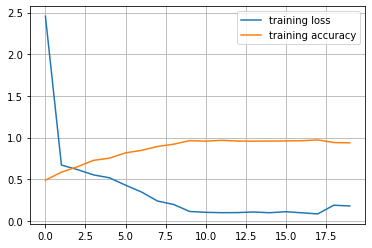

In [17]:
## stats on training data
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.grid(True)
plt.legend()

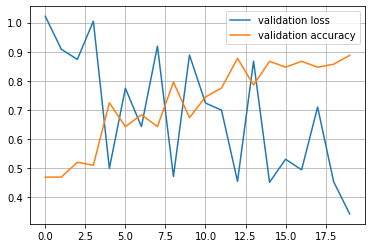

In [18]:
## stats on training data
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.grid(True)
plt.legend()

4/4 [==============================] - 1s 73ms/step


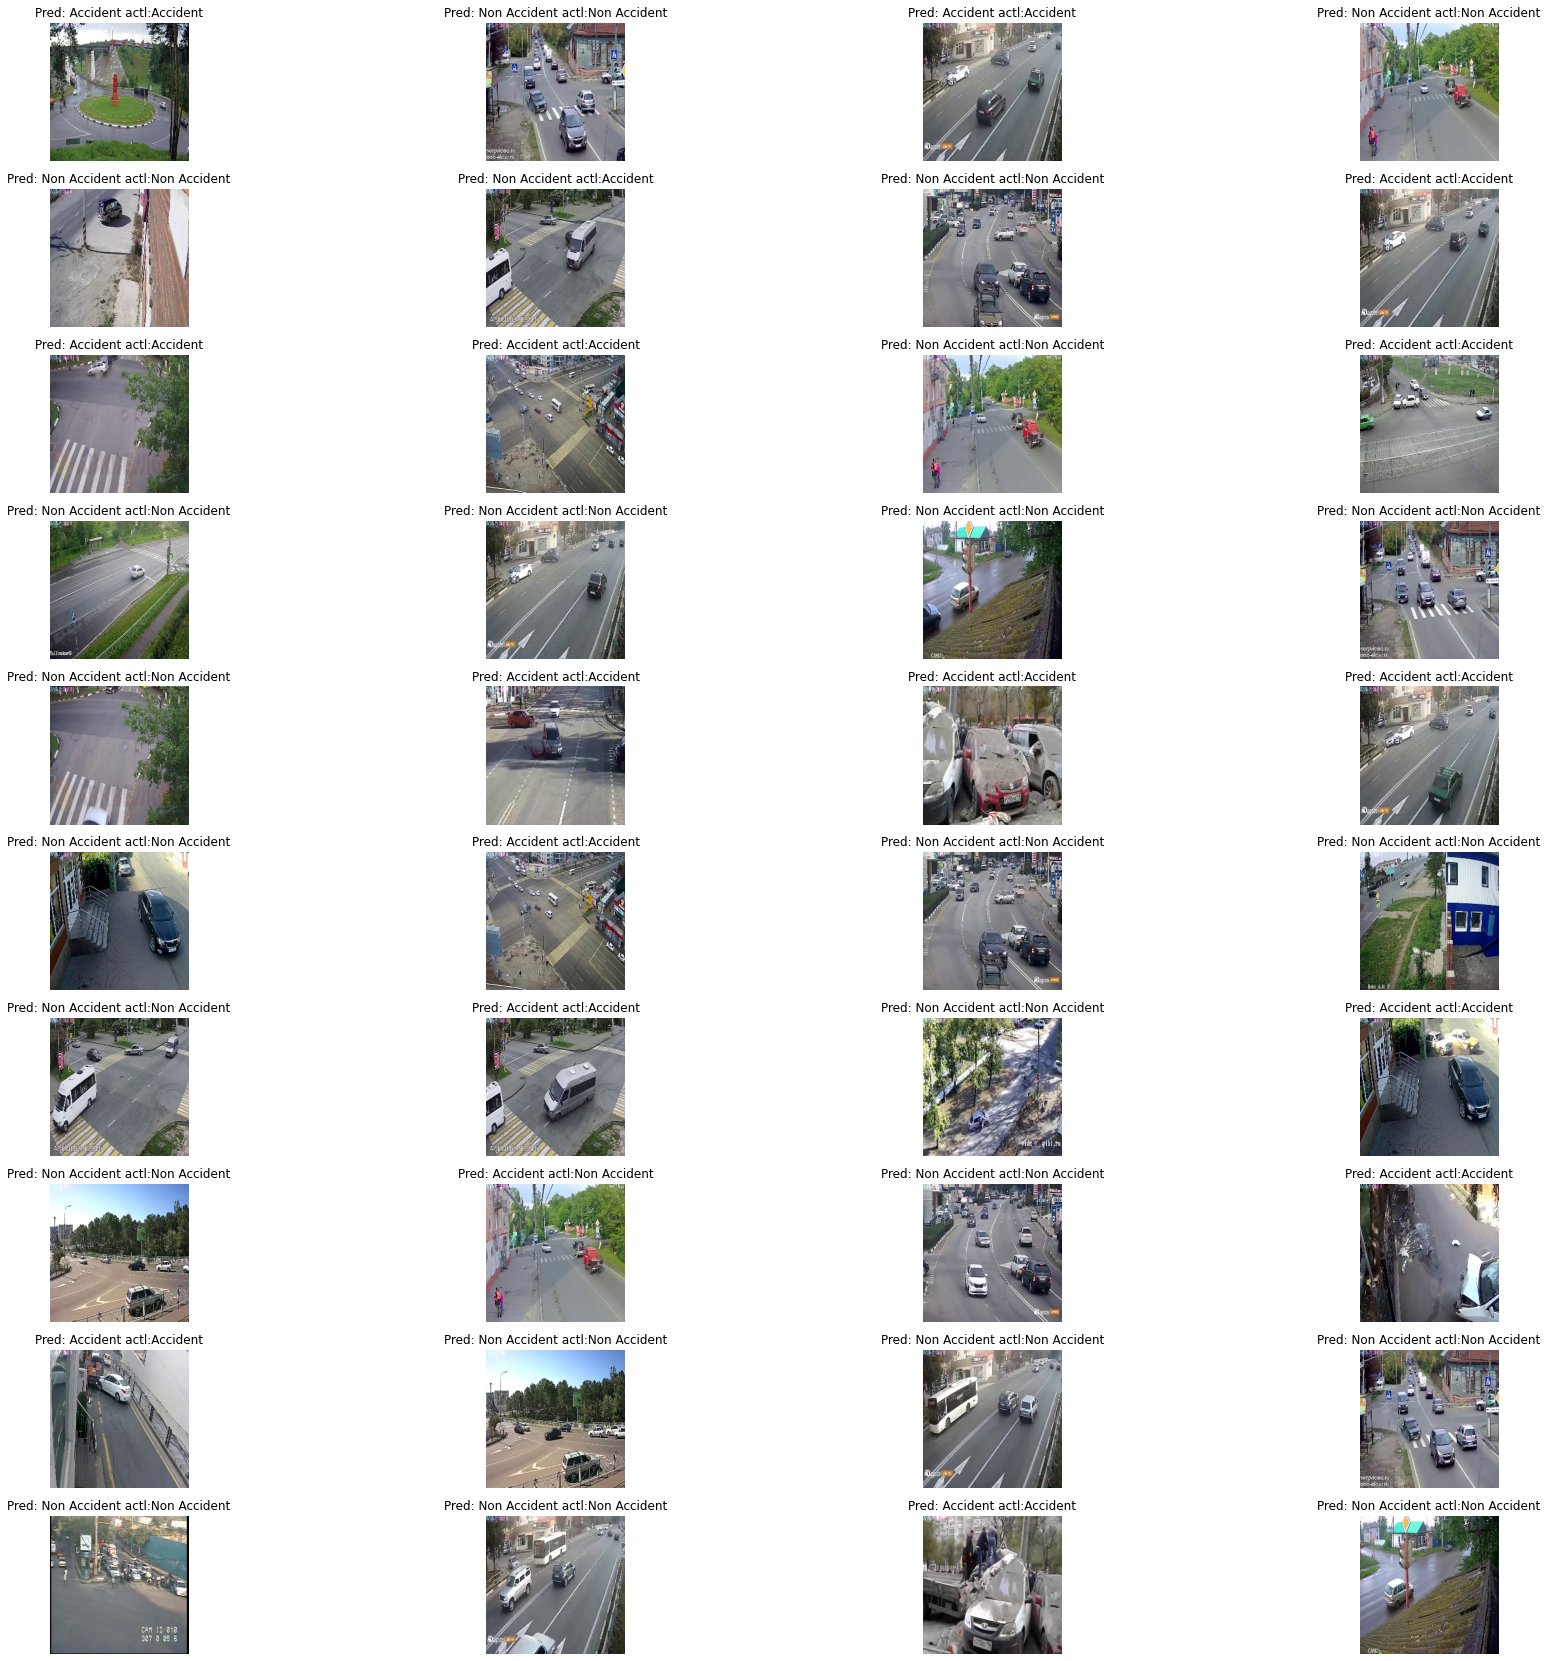

In [19]:
## lets vizualize results on testing data
AccuracyVector = []
plt.figure(figsize=(30, 30))
for images, labels in testing_data.take(1):
    predictions = model.predict(images)
    predlabel = []
    prdlbl = []
    
    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))
    
    AccuracyVector = np.array(prdlbl) == labels
    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Pred: '+ predlabel[i]+' actl:'+class_names[labels[i]] )
        plt.axis('off')
        plt.grid(True)

PREDICTION

In [20]:
from keras.models import model_from_json
import numpy as np

class AccidentDetectionModel(object):

    class_nums = ['Accident', "No Accident"]

    def __init__(self, model_json_file, model_weights_file):
        # load model from JSON file
        with open(model_json_file, "r") as json_file:
            loaded_model_json = json_file.read()
            self.loaded_model = model_from_json(loaded_model_json)

        # load weights into the new model
        self.loaded_model.load_weights(model_weights_file)
        self.loaded_model.make_predict_function()

    def predict_accident(self, img):
        self.preds = self.loaded_model.predict(img)
        return AccidentDetectionModel.class_nums[np.argmax(self.preds)], self.preds

In [22]:
model = AccidentDetectionModel("model.json", 'model_weights.h5')
import cv2

In [24]:
video = cv2.VideoCapture('/content/videoplayback.mp4') # for camera use video = cv2.VideoCapture(0)
while True:
        ret, frame = video.read()
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        roi = cv2.resize(gray_frame, (250, 250))

        pred, prob = model.predict_accident(roi[np.newaxis, :, :])
        if(pred == "Accident"):
            prob = (round(prob[0][0]*100, 2))
            if(prob>=90):
              print("accident detected " + str(prob))
            # to beep when alert:
            # if(prob > 90):
            #     os.system("say beep")

            # cv2.rectangle(frame, (0, 0), (280, 40), (0, 0, 0), -1)
            # cv2.putText(frame, pred+" "+str(prob), (20, 30), 1, (255, 255, 0), 2)

        if cv2.waitKey(33) & 0xFF == ord('q'):
            break
        # cv2.imshow('Video', frame)

1/1 [==============================] - 0s 23ms/step
accident detected 91.74
1/1 [==============================] - 0s 22ms/step
accident detected 91.37
1/1 [==============================] - 0s 25ms/step
accident detected 90.57
1/1 [==============================] - 0s 20ms/step
accident detected 90.3
1/1 [==============================] - 0s 17ms/step
accident detected 94.04
1/1 [==============================] - 0s 15ms/step
accident detected 94.24
1/1 [==============================] - 0s 15ms/step
accident detected 96.06
1/1 [==============================] - 0s 16ms/step
accident detected 95.81
1/1 [==============================] - 0s 14ms/step
accident detected 96.57
1/1 [==============================] - 0s 15ms/step
accident detected 96.63
1/1 [==============================] - 0s 16ms/step
accident detected 97.04
1/1 [==============================] - 0s 23ms/step
accident detected 96.63
1/1 [==============================] - 0s 17ms/step
accident detected 97.58
1/1 [========

error: ignored